# Adversarial Chess
6.4212 Final Project

Kameron Dawson

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    DiagramBuilder, StartMeshcat, Simulator, Rgba, RigidTransform
)
from pydrake.geometry import Sphere
from manipulation.station import LoadScenario, MakeHardwareStation, AddPointClouds
from manipulation.utils import RenderDiagram
from setup_simulation import get_scenario
from utils import visualize_box, visualize_text
from perception.point_cloud import get_scene_point_cloud, get_model_point_clouds
from perception.clustering import cluster_point_cloud_hybrid
from perception.perception import segment_scene_point_cloud, classify_piece_colors, match_scene_to_model_cloud_bb
from perception.axis import get_piece_cloud_main_axis
from perception.bounding_box import orient_cloud

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Setup meshcat for visualization
meshcat = StartMeshcat()
print('Click the link above to open Meshcat in your browser!')

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [3]:
# Clear meshcat
meshcat.Delete()

In [4]:
# Get scenario
scenario_string = get_scenario()

# Load the scenario and build the simulation station
scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)

# Build a Drake Diagram containing the station
builder = DiagramBuilder()
builder.AddSystem(station)

# Setup getting point clouds from the cameras
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)
builder.ExportOutput(to_point_cloud["camera0"].get_output_port(), "camera0_point_cloud")
builder.ExportOutput(to_point_cloud["camera1"].get_output_port(), "camera1_point_cloud")
builder.ExportOutput(to_point_cloud["camera2"].get_output_port(), "camera2_point_cloud")

# Build diagram
diagram = builder.Build()

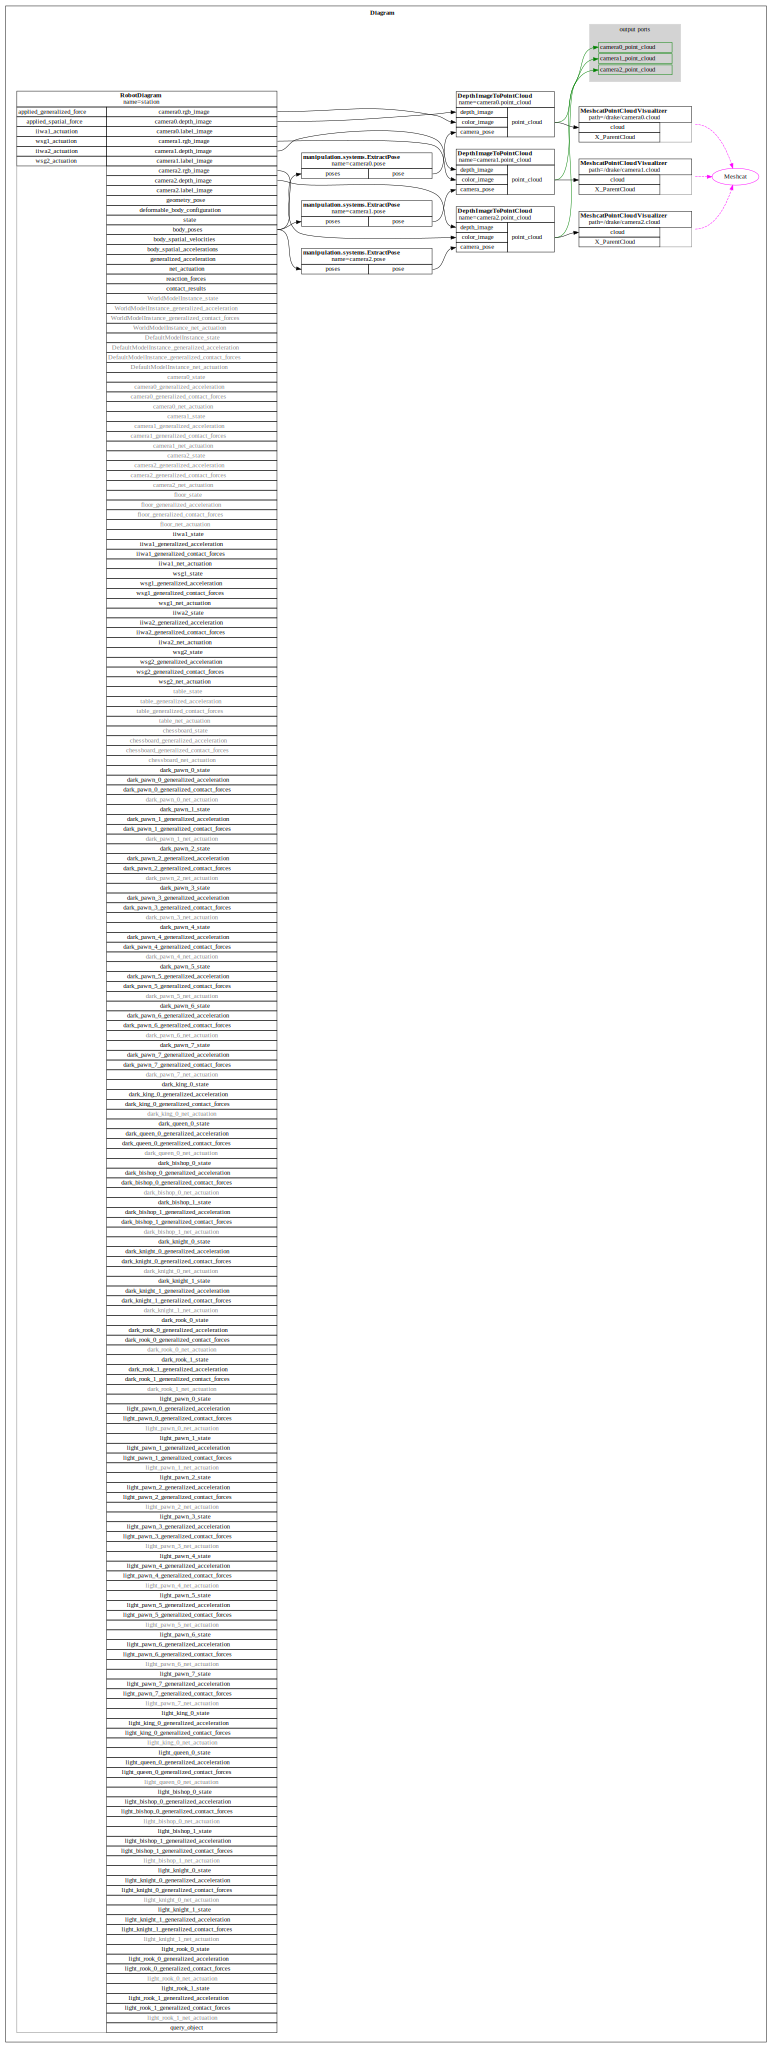

In [5]:
RenderDiagram(diagram, max_depth=1)

In [6]:
# Get relevant vars from the diagram
context = diagram.CreateDefaultContext()

In [7]:
# Create and run a simulator
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.1)

## Perception

### Sanity Checks

In [ ]:
# Run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

plt.show()

In [ ]:
# Run the following cell to visualize the depth outputs of each of the cameras
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()

### ICP

In [8]:
# Get scene point cloud from depth cameras, then segment it by cropping out known objects (floor, table, chessboard, iiwas)
scene_point_cloud = segment_scene_point_cloud(get_scene_point_cloud(diagram, context), 0.001)

In [9]:
# Sanity checks of scene point cloud
print('Num scene points: ', scene_point_cloud.size())
xyzs = scene_point_cloud.xyzs()
x = xyzs[0]
y = xyzs[1]
z = xyzs[2]

print('min, max xyz:')
min_x, max_x = min(x), max(x)
min_y, max_y = min(y), max(y)
min_z, max_z = min(z), max(z)
print(min_x, max_x)
print(min_y, max_y)
print(min_z, max_z)

Num scene points:  8591
min, max xyz:
-0.17744415 0.1799749
-0.1755087 0.17810935
0.5281069 0.5887327


In [ ]:
# Visualize scene point cloud
meshcat.SetObject(
    "scene_point_cloud", scene_point_cloud, point_size=0.05, rgba=Rgba(1, 0, 0)
)

In [10]:
# Scene point cloud only contains piece clouds
piece_clouds = cluster_point_cloud_hybrid(scene_point_cloud)

In [ ]:
# Visual piece cloud centroids
for i, piece_cloud in enumerate(piece_clouds):
    pts = piece_cloud.xyzs()
    centroid = np.mean(pts, axis=1)
    X = RigidTransform()
    X.set_translation(centroid)
    path = f'/piece/{i}'
    meshcat.SetTransform(path, X)
    meshcat.SetObject(
        path, Sphere(0.01), Rgba(0, 0, 1)
    )

In [ ]:
# Visualize piece clouds
for i, cluster in enumerate(piece_clouds):
    meshcat.SetObject(
        f"cluster_point_cloud_{i}", cluster, point_size=0.05, rgba=Rgba(1, 0, 0)
    )

In [11]:
# Separate piece clouds into the dark and light sets
color_classifications = classify_piece_colors(piece_clouds)
piece_clouds_by_color = {'dark': [], 'light': []}
for color, cluster in zip(color_classifications, piece_clouds):
    piece_clouds_by_color[color].append(cluster)
    

In [ ]:
# Visualize color classified piece clouds
i = 0
for color, cluster in zip(color_classifications, piece_clouds):
    rgb = Rgba(1, 1, 1) if color == 'light' else Rgba(0, 0, 0)
    meshcat.SetObject(
        f"cluster_point_cloud_{color}_{i}", cluster, point_size=0.0025, rgba=rgb
    )
    i += 1

In [12]:
# Get model point clouds
model_point_clouds = get_model_point_clouds()
model_piece_point_clouds = model_point_clouds['pieces']

# Orient the model piece point clouds
oriented_model_piece_point_clouds = {}
main_axis = np.array([0, 1, 0]) # models sits on their side in the y direction
for color, models in model_piece_point_clouds.items():
    oriented_model_piece_point_clouds[color] = {}
    for name, pc in models.items():
        oriented_pc = orient_cloud(pc, main_axis)
        oriented_model_piece_point_clouds[color][name] = oriented_pc

In [13]:
# Sanity checks
for color, models in model_piece_point_clouds.items():
    for name, pc in models.items():
        main_axis = get_piece_cloud_main_axis(pc)
        y = abs(main_axis[1])
        if abs(y - 1) > 0.001:
            print(color, name, main_axis)

for color, models in oriented_model_piece_point_clouds.items():
    for name, pc in models.items():
        main_axis = get_piece_cloud_main_axis(pc)
        z = main_axis[2]
        if abs(z - 1) > 0.001:
            print(color, name, main_axis)

In [14]:
# Sanity check
for color, models in piece_clouds_by_color.items():
    for pc in models:
        main_axis = get_piece_cloud_main_axis(pc)
        z = main_axis[2]
        if abs(z - 1) > 0.02:
            print(color, main_axis)

In [15]:
# Match scene clusters to model clouds using bounding boxes
dark_poses = match_scene_to_model_cloud_bb(piece_clouds_by_color['dark'], oriented_model_piece_point_clouds['dark'])
light_poses = match_scene_to_model_cloud_bb(piece_clouds_by_color['light'], oriented_model_piece_point_clouds['light'])

In [17]:
colors = {
    'pawn': Rgba(1, 0, 0), # red
    'king': Rgba(0, 1, 0), # green
    'queen': Rgba(0, 0, 1), # blue
    'bishop': Rgba(1, 1, 0), # yellow
    'knight': Rgba(0, 1, 1), # cyan
    'rook': Rgba(1, 0, 1) # magenta
}

for piece, cloud in zip(dark_poses, piece_clouds_by_color['dark']):
    name = piece[:-1]
    # Get piece pose
    pts = cloud.xyzs()
    centroid = np.mean(pts, axis=1)
    X = RigidTransform()
    X.set_translation(centroid)
    # Visualize centroid
    path = f'/piece/dark/{piece}'
    meshcat.SetTransform(path, X)
    meshcat.SetObject(
        path, Sphere(0.01), rgba=colors[name]
    )

for piece, cloud in zip(light_poses, piece_clouds_by_color['light']):
    name = piece[:-1]
    # Get piece pose
    pts = cloud.xyzs()
    centroid = np.mean(pts, axis=1)
    X = RigidTransform()
    X.set_translation(centroid)
    # Visualize centroid
    path = f'/piece/light/{piece}'
    meshcat.SetTransform(path, X)
    meshcat.SetObject(
        path, Sphere(0.01), rgba=colors[name]
    )

In [ ]:
for cloud in piece_clouds_by_color['dark']:
    pts = cloud.xyzs()
    x, y, z = pts[0], pts[1], pts[2]
    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    min_z, max_z = np.min(z), np.max(z)
    lower, upper = np.array([min_x, min_y, min_z]), np.array([max_x, max_y, max_z])
    visualize_box(meshcat, lower, upper)